## Interpolation Module

## Introduction
To simulate Daedalus measurments using physics based model such as TIEGCM 
values of gridded data have to be interpolateds to the spacecraft's positions.In
Daedalus Maze this is provided by the Interpolation Module which is described below.

The Interpolation Module consists of a family of  codes written in python FORTRAN and C++.

## Basic Input and Output
The Interpolation Module supports Dedalus Input orbits in netcdf format and exports the interpolation
results in netcdf as well.

## Performance and Parallelization Level
The python version of the Inteprolation Modules supports single threaded and multi threaded workloads using the multiprocessing library. At the same, the user can opt to call the pre-compiled low-level FORTRAN subroutines which can handle both the single threaded and the multi threaded interpolations using OpenMP.

The C++ version, uses the OpenMPI and OpenMP interface and can support massive scalability on distributed memory using hybrid programming,splitting the interpolations in threads and nodes.The same basic input and output interface is used as with the python version.

Finally there is a version of the Interpolation Module written in C++ using a CUDA kernel to speed up the interpolation process. On a shared memory environment this is by far the fastest version, outperforming the 
python version by more than three orders of magnitude.






## Skeleton of the Interpolation Module


## The Model Class: 
This class handles basic IO of the Model Data extracting grid quintities and variables as selected by
the user to be used in the interpolation.


In [1]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
%matplotlib inline  
import pandas as pd
import numpy as np
import pandas as pd
from pandas import DataFrame
from datetime import datetime
import time
import os
import sys
import multiprocessing
from functools import partial
from scipy.signal import savgol_filter
import warnings
warnings.filterwarnings('ignore')

startTime = 0

In [2]:

class Model:
    def __init__(self,name, maxAltitude, minAltitude):
        self.name=name
        self.maxAltitude=maxAltitude
        self.minAltitude=minAltitude
        self.dt=0.0



    def readGrid(self,name):
        TIEGCM=Dataset(name+".nc")
        glat=TIEGCM.variables['lat'][:]
        glon=TIEGCM.variables['lon'][:]
        glev=TIEGCM.variables['lev'][:]
        gtime=TIEGCM.variables['time'][:] 
        zg=TIEGCM.variables['ZGMID'][:]
        TIEGCM.close()
        self.dt= gtime[2]- gtime[1]
       
        return np.asarray(gtime),np.asarray(glat),np.asarray(glon),np.asarray(glev),np.asarray(zg)

    def readVar(self,model,name):
        TIEGCM=Dataset(model+".nc")
        var   = TIEGCM.variables[name][:]
        units = TIEGCM.variables[name].units
        TIEGCM.close()
        return var, units


## The Orbit Class: 
This class  This class handles basic IO of Daedalus' orbit allocating arrays for the spatial components. The longitudinal component is matched to TIEGCM's  and points in a specific altitudinal range are extracted to be passed to the interpolation routine. There is also an option for creating a Rocket orbit for getting 
vertical profiles of the said model.

In [3]:

class Orbit:
    def __init__(self,name):
        self.name=name
        self.dt=1/16



    def createorbit(self,filename,minAlt,maxAlt,outfile,Save=False):
        orbit=Dataset(filename+".nc","r")
        daed_lat_temp = orbit.variables['lat'][:]
        daed_lon_temp = orbit.variables['lon'][:]
        daed_alt_temp = orbit.variables['altitude'][:]
        daed_time_temp = orbit.variables['time'][:] #unix time
        
        global startTime
        startTime = daed_time_temp[0]
        

#         self.dt=daed_time_temp[2]-daed_time_temp[1]
        self.Save=Save
        
        if self.Save==True:
            self.OpenFile(outfile,daed_time_temp,daed_lat_temp,daed_lon_temp,daed_alt_temp)
        
        stop=False
        counter=0
        for i in range(0,len(daed_alt_temp)):
            if (daed_alt_temp[i] < maxAlt and daed_alt_temp[i] > minAlt):
                counter=counter+1

        
        
        daed_lat=np.zeros((counter))
        daed_lon=np.zeros((counter))
        daed_alt=np.zeros((counter))
        daed_time=np.zeros((counter),dtype=datetime)
        index=[None]*counter
        int_final=[None]*len(daed_alt_temp)


   
        counter2=0
        
        for i in range(0,len(daed_alt_temp)):
    
            if (daed_alt_temp[i] < maxAlt and daed_alt_temp[i] > minAlt):
         
                daed_time[counter2]=daed_time_temp[i]
                daed_lat[counter2]=daed_lat_temp[i]
                if max(daed_lon_temp)>180:
                    daed_lon[counter2]=daed_lon_temp[i]-180 #match TIEGCM grid
                else:
                    daed_lon[counter2]=daed_lon_temp[i]
                daed_alt[counter2]=daed_alt_temp[i]
                
                index[counter2]=i          #keep indices for merging data
                counter2=counter2+1
        

        return(daed_time,daed_lat,daed_lon,daed_alt,index,int_final)

    def RockeOrbit(self,lat,lon,alt,nop,dz):
        Rlat=np.zeros(nop)
        Rlon=np.zeros(nop)
        Ralt=np.zeros(nop)

        Rlat[:]=lat
        Rlon[:]=lon
        Ralt[0]=alt
        for i in range(1,nop):
            Ralt[i]=Ralt[i-1]+dz

        return Rlat,Rlon,Ralt

    def mergeData(self,index,int_final,m):
        for i in range(0,len(m)):
            int_final[index[i]]=m[i]

        return int_final    



    def OpenFile(self,outfile,time,lat,lon,alt):
        print("Output File Path:",outfile)
        ncout = Dataset(outfile, "w", format="NETCDF4")    
        ncout.createDimension("time", len(time))
        xaxis=np.arange(0,len(time)) #time axis based on Daedalus Sampling rate
        data = ncout.createVariable("time","f4","time")
        data[:]=xaxis
        ncout.createDimension("lat",len(lat))
        data = ncout.createVariable("lat","f4","lat")
        data[:]=lat
        ncout.createDimension("lon",len(lon))
        data = ncout.createVariable("lon","f4","lon")
        data[:]=lon
        ncout.createDimension("altitude",len(alt))
        data = ncout.createVariable("altitude","f4","time")
        data[:]=alt
        ncout.close()   
        return True



Functions used by the Interpolation Module
The geod2geo_lat converts geodetic latitude to geographic latitude

In [4]:
def geod_lat2geo_lat(phi):

    # calculate geocentric latitude from geodetic latitude
    # according to WGS 84
    a = 6378137  # meter semi major axis of earth
    f = 1 / 298.257  # flattening
    b = a - f * a  # semi minor axis
    e = ((a ** 2 - b ** 2) ** (1 / 2)) / a
    phi_rad = np.deg2rad(phi)
    geo_lat = np.arctan((1 - e ** 2) * np.tan(phi_rad))
    geo_lat = np.rad2deg(geo_lat)
    return geo_lat  # in degrees

The function local is used to find the local neighbors of a specific component in a non eqwually spaced array 
such as the pressure levels in the TIEGCM

In [5]:

def local(dim1,y,x):
    local_pos=0
    for i in range(0,len(x)-1):
        if y >= x[i] and y < x[i+1]:
            local_pos=i
            return (local_pos)
    return (local_pos)

The single threaded inteprolation core routine which iterates over Daedalus orbit and performs the interpolation.
At every spatial position weights are assigned to the  8 local grid neighbours and then the interpolated value is calculated using trilinear interpolation.

In [6]:
from tqdm import tqdm
def Interpolate_Serial(glat,glon,glev,dtime,dlat,dlon,dalt,zg,ne,Plot=False,thisLabel="TN"):
    counter=TIEGCMtiemstep_widget.value #counter=11
    deltaphi= np.abs(glon[2]-glon[1])
    deltatheta=np.abs(glat[2]-glat[1])
    Re=6378137.0/1e3
    # arc_theta=2*np.pi*Re*(deltatheta/360)
    # arc_phi=2*np.pi*Re*(deltaphi/360)

    m=np.zeros((len(dalt)))
    tn=np.zeros((len(dalt)))
    pn=np.zeros((len(dalt)))

    for i in range(0,len(dalt)):


        
        phi_local=local(len(glon),dlon[i],glon)
        theta_local=local(len(glat),dlat[i],glat)


        if dlon[i] >= 177.5 :
            phi_local=len(glon)-2
            lonbnd=1

        if dlon[i] <= -177.5:
            phi_local=1

        if dlat[i] >= 87.5:
            theta_local=len(glat)-2
            latbnd=1

        if dlat[i] <= -87.5:
            theta_local=0


        alts=zg[counter,:,theta_local,phi_local]/1e5
        r_local=local(len(alts),dalt[i],alts)
        deltarho=alts[r_local+1]-alts[r_local]
        dx=(((dalt[i]-alts[r_local])/deltarho))
        dy=(((dlat[i]-glat[theta_local])/deltatheta))
        dz=np.abs(((dlon[i]-glon[phi_local])/deltaphi))

        # Calculate Neighbors
        pn[i]=ne[counter,r_local,theta_local,phi_local]

        
        w1=np.abs((1-dx)*(1-dy)*(1-dz))
        w2=np.abs((dx)*(1-dy)*(1-dz))
        w3=np.abs((1-dx)*(dy)*(1-dz))
        w4=np.abs((dx)*(dy)*(1-dz))
        w5=np.abs((1-dx)*(1-dy)*(dz))
        w6=np.abs((dx)*(1-dy)*(dz))
        w7=np.abs((1-dx)*(dy)*(dz))
        w8=np.abs((dx)*(dy)*(dz))

        
        m[i]=0.0
        m[i]=       ne[counter,r_local,theta_local,phi_local]*w1
        m[i]=m[i]+  ne[counter,r_local+1,theta_local,phi_local]*w2
        m[i]=m[i]+  ne[counter,r_local,theta_local+1,phi_local]*w3
        m[i]=m[i]+  ne[counter,r_local+1,theta_local+1,phi_local]*w4

        m[i]=m[i]+  ne[counter,r_local,theta_local,phi_local+1]*w5
        m[i]=m[i]+  ne[counter,r_local+1,theta_local,phi_local+1]*w6
        m[i]=m[i]+  ne[counter,r_local,theta_local+1,phi_local+1]*w7
        m[i]=m[i]+  ne[counter,r_local+1,theta_local+1,phi_local+1]*w8
      

    return (m)



def Write(outfile,m,varname):

    ncout = Dataset(outfile, "a", format="NETCDF4")
    data = ncout.createVariable(varname,"f4",('time'))
    data[:]=m
    ncout.close()
    

## Random Noise Generation Using Fourier Series

We used a method for generating Gaussian noise sequences with arbitrary power spectra taken from: *Grauer, Jared. (2018). Random Noise Generation Using Fourier Series. Journal of Aircraft. 55. 1-7. 10.2514/1.C034616.* 

The method uses the Fourier series, where the amplitude spectrum is assigned according to the desired power spectra, and phase angles are drawn randomly from a uniform distribution.


In [7]:
def fftnoise(f):
    f = np.array(f, dtype='complex')
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1:Np+1] *= phases
    f[-1:-1-Np:-1] = np.conj(f[1:Np+1])
    return np.fft.ifft(f).real

def band_limited_noise(min_freq, max_freq, samples=1024, samplerate=1):
    freqs = np.abs(np.fft.fftfreq(samples, 1/samplerate))
    f = np.zeros(samples)
    idx = np.where(np.logical_and(freqs>=min_freq, freqs<=max_freq))[0]
    f[idx] = 1
    return fftnoise(f)

By using a Gaussian function as a filter, we restricted this noise to be applied only at the area of interest (lat >55 degrees)

In [8]:
def interpolationNoise(idata, dtime, dlat, dalt, Plot=False, thisLabel="TN"):
    
    noise = band_limited_noise(0.1, 0.9, len(idata), 1)
    
    min=np.zeros((len(dtime)))
    for i in range(0,len(dtime)):
        min[i] = (dtime[i] - startTime)/1000/60
    
    #plt.plot(min, noise*400)
    
    max = np.argmax(idata)        
    peak = np.argmax(dlat)
    
    #if dlat[peak] < 55:
     #   return idata
    
    i = peak
    countLeft = 0
    while i >0:
        if dlat[i] >= 55:
            countLeft += 1
            i -= 1
        else:
            break
    
    
    i = peak
    countRight = 0
    while i < len(dlat)-1:
        if dlat[i] >= 55:
            countRight += 1
            i += 1
        else:
            break
        
    width = countLeft
    if(countRight > countLeft):
        width = countRight
    
    xpoints = np.linspace(0, len(dtime)-1, len(dtime))
    height = 1
    mean = peak
    #width = width 

    yfilter = height * np.exp( - ((xpoints-mean)/width)**2 )
    
    
    if Plot== True:
        fig = plt.figure()
        fig.set_figheight(30)
        fig.set_figwidth(7)
        
        ax1 = fig.add_subplot(711)
        ax2 = fig.add_subplot(712)
        ax3 = fig.add_subplot(713)
        ax4 = fig.add_subplot(714)
        ax5 = fig.add_subplot(715)
        ax6 = fig.add_subplot(716)
        ax7 = fig.add_subplot(717)


        ax1.plot(min,idata)
        ax2.plot(min,dlat)
        ax3.plot(min,dalt)
        ax4.plot(min,noise)
        ax5.plot(min,yfilter)
        ax6.plot(min,yfilter*noise)
        ax7.plot(min,idata+yfilter*noise*idata[max])
        
        ax1.set_ylabel(thisLabel, fontsize=14)
        ax2.set_ylabel("Lat [deg]", fontsize=14)
        ax3.set_ylabel("Altitude [km]", fontsize=14)
        ax4.set_ylabel("Random Noise", fontsize=14)
        ax5.set_ylabel("Filter", fontsize=14)
        ax6.set_ylabel("Filtered Noise", fontsize=14)
        ax7.set_ylabel(thisLabel, fontsize=14)
        
        plt.suptitle('Interpolated Data (from ' + str(datetime.utcfromtimestamp(startTime/1000.0).strftime('%Y-%m-%d %H:%M:%S')) + ')', fontsize=24)
        plt.xlabel("Time (min)", fontsize=14)
        plt.show() 
    
    return idata+yfilter*noise*idata[max]
    
    

    

In [9]:
    
    
from ipywidgets import*
import ipywidgets as widgets
import warnings
import sys
sys.path.insert(1, "../SourceCode")
import DaedalusGlobals as DaedalusGlobals
import glob
import os

layout1 = {'width':'850px'}
style1 = {'description_width':'150px'}
layout2 = {'width':'180px'}
style2 = {'description_width':'100px'}
layout1_with_borders = Layout( border='solid 2px green', width='850px' )
TIEGCMtiemstep_widget = widgets.IntText( value=1, description='TIEGCM timestep:', style=style1, layout=layout1)
Noise_enable_widget   = widgets.Checkbox( value=True, description='Apply Noise')
SGV_enable_widget     = widgets.Checkbox( value=True, description='Apply Sub-Grid-Variability')
SGV_amplitude_widget  = widgets.FloatText( value=200, description=' with Amplitude:', style=style2, layout=layout2)
SGV_scale_widget      = widgets.FloatText( value=100, description=' and Max Scale:',  style=style2, layout=layout2)
SGV_cuda_widget       = widgets.Checkbox( value=True, description='Run with CUDA')


def LoadGUI():
   
    layout1 = {'width':'850px'}
    style1 = {'description_width':'150px'}
    
    tiegcm_file=widgets.Dropdown(options=sorted(glob.glob(DaedalusGlobals.TIEGCM_Files_Path +"TIEGCM_EVT1_2015_StPatricksDay_Rerun/*.nc")), description='TIE-GCM files: ', style=style1, layout=layout1)
    tiegcm_file.value = "/home/NAS/TIEGCM_DATA/TIEGCM_EVT1_2015_StPatricksDay_Rerun/tiegcm_dres.s_mar2015_amie_v1_31_Rerun.nc"
    orbit_file=widgets.Dropdown(options=sorted(glob.glob(DaedalusGlobals.Orbit_Files_Path +"DAED_ORB_Evt0_LLA*.nc")), description='Orbit files: ', style=style1, layout=layout1)
    saveOption= widgets.Checkbox(value=False,  description="Save Output",style=style1, layout=layout1)
    TGvar=widgets.Dropdown(
            options=['All','XNMBAR','TI','TN','OP','DEN','HALL','HE','PEDERSEN','POTEN','TE',
                    'O2_CM3', 'EEX', 'EEY', 'EEZ', 'ELECDEN', 'N2_CM3', 'NOP_LAM', 'NPLUS', '02P', 'O_CM3'
                    'UN', 'VN', 'WN_lev', 'HALL', 'N2D', 'N4S', 'NO', 'Ui_lev', 'Vi_lev', 'WI_LEV'],
            value='EEX',
            description='TIEGCM Variable:',
            disabled=False,
            style=style1, 
            layout=layout1
            )
    def Exec_Btn_Clicked( b ):
        
        print( "Interpolation started..." )
        
        if TGvar.value=='All':
            thisLabel="TN"
            tgvars=['All','XNMBAR','TI','TN','OP','DEN','HALL','HE','PEDERSEN','POTEN','TE',
                    'O2_CM3', 'EEX', 'EEY', 'EEZ', 'ELECDEN', 'N2_CM3', 'NOP_LAM', 'NPLUS', '02P', 'O_CM3'
                    'UN', 'VN', 'WN_lev', 'HALL', 'N2D', 'N4S', 'NO', 'Ui_lev', 'Vi_lev', 'WI_LEV']
            RunInterpolator(os.path.splitext(tiegcm_file.value)[0],os.path.splitext(orbit_file.value)[0],tgvars,saveOption.value,thisLabel)
        else:
            thisLabel="TN"
            tgvars=[TGvar.value]
            if (TGvar.value=="XNMBAR"):
                thisLabel="Conversion Factor "
            if (TGvar.value=="TI"):
                thisLabel="Ion Temperature [K] "
            if (TGvar.value=="TN"):
                thisLabel="Neutral Temperature [K] "
            if (TGvar.value=="OP"):
                thisLabel="O+ ion [cm^-3] "
            if (TGvar.value=="DEN"):
                thisLabel="Total Density [g/cm3] "
            if (TGvar.value=="HALL"):
                thisLabel="Hall conductivity [S/m] "                
            if (TGvar.value=="HE"):
                thisLabel="Helium [mmr] " 
            if (TGvar.value=="PEDERSEN"):
                thisLabel="Pendersen condcutivity [S/m] "                 
            if (TGvar.value=="POTEN"):
                thisLabel="Electric Potential [Volts] "   
            if (TGvar.value=="TE"):
                thisLabel="Electorn Temperature [K] "     
            if (TGvar.value=="O2_CM3"):
                thisLabel="Molecular Oxygen [cm^-3] "    
            if (TGvar.value=="O2_CM3"):
                thisLabel="Molecular Oxygen [cm^-3] "                           
            if (TGvar.value=="EEX"):
                thisLabel="Electric Field East"
            if (TGvar.value=="EEY"):
                thisLabel="Electric Field North"
            if (TGvar.value=="EEZ"):
                thisLabel="Electric Field Up"
            if (TGvar.value=="ELECDEN"):
                thisLabel="Electron Density [cm^-3] "
            if (TGvar.value=="N2_CM3"):
                thisLabel="Molecular Nitrogen [cm^-3] "
            if (TGvar.value=="NOP_LAM"):
                thisLabel="NO+ Ion [cm^-3] "
            if (TGvar.value=="NPLUS"):
                thisLabel="N+ Ion [cm^-3] "
            if (TGvar.value=="02P"):
                thisLabel="O2+ Ion  [cm^-3] "
            if (TGvar.value=="O_CM3"):
                thisLabel="Atomic Oxygen  [cm^-3] "
            if (TGvar.value=="UN"):
                thisLabel="Neutral Zonal Wind  [cm/s] "
            if (TGvar.value=="VN"):
                thisLabel="Meridional Zonal Wind [cm/s] "
            if (TGvar.value=="WN_lev"):
                thisLabel="Vertical Zonal Wind [cm/s] "
            if (TGvar.value=="HALL"):
                thisLabel="Hall conductivity [S/m] "
            if (TGvar.value=="N2D"):
                thisLabel="N2D [mmr] "
            if (TGvar.value=="N4S"):
                thisLabel="N4S [mmr] "
            if (TGvar.value=="NO"):
                thisLabel="Nitric Oxide [mmr] "
            if (TGvar.value=="Ui_lev"):
                thisLabel="Zonal ExB velocity [cm/s] "
            if (TGvar.value=="Vi_lev"):
                thisLabel="Meridional ExB velocity [cm/s] "
            if (TGvar.value=="WI_LEV"):
                thisLabel="Vertical ExB velocity [cm/s] "
                
                
            RunInterpolator(os.path.splitext(tiegcm_file.value)[0],os.path.splitext(orbit_file.value)[0],tgvars,saveOption.value,thisLabel)
  

    def createGUI():
        MainPanel = widgets.VBox() 
        MainTab = widgets.Tab() 
        VerticalPanel = widgets.VBox()
        MapPanel = widgets.VBox()
        MainTab.children = [ VerticalPanel ]
        MainTab.set_title(0, 'Interpolator')
        MainPanel.children = [MainTab ]   
        Exec_Btn = widgets.Button (description='Run',tooltip="Click here to Interpolate",)
        Exec_Btn.style.button_color = 'Red'
        Exec_Btn.on_click( Exec_Btn_Clicked )
        NOISEpanel = widgets.HBox( [Noise_enable_widget], style=style1, layout=layout1_with_borders )
        SGVpanel = widgets.HBox( [SGV_enable_widget, SGV_amplitude_widget, SGV_scale_widget, SGV_cuda_widget], style=style1, layout=layout1_with_borders )
        VerticalPanel.children = [tiegcm_file, TIEGCMtiemstep_widget, orbit_file, TGvar, saveOption, NOISEpanel, SGVpanel, Exec_Btn]
    
        return MainPanel
    display( createGUI() )


def RunInterpolator(model_data_file,orbit_file,TGvar,Save=False,thisLabel="TN"):
    model=Model(model_data_file ,500,100)  #initialize model
    orbit=Orbit(orbit_file)                #initialize  orbit
    outfile=os.getenv("HOME")+"/"+os.path.basename(model_data_file)+"_Interpolated.nc"
    dtime,dlat,dlon,dalt,index,int_final=orbit.createorbit(orbit.name,model.minAltitude,model.maxAltitude,outfile,Save)
    gtime,glat,glon,glev,zg=model.readGrid(model.name)                                     #get model stats
    

    
    #select variable
    for jj in tqdm(range(len(TGvar))):
        var, units = model.readVar(model.name,TGvar[jj])
        interpolatedData1      = Interpolate_Serial(glat,glon,glev,dtime, dlat,dlon,dalt,zg,var,True,thisLabel)
        # convert units if necessary
        if units == "V/cm":
            units = "mV/m"
            interpolatedData1 *= 100000
        # apply noise to data if user says so
        if Noise_enable_widget.value == True:
            interpolationNoiseData = interpolationNoise(interpolatedData1, dtime, dlat, dalt, True, thisLabel)
        else:
            interpolationNoiseData = interpolatedData1
        # apply Sub-Grid-Variability to data if user says so
        if SGV_enable_widget.value == True:
            DataPlusVariability    = ApplySGV( interpolationNoiseData, dlat, dlon, dalt, thisLabel, units, SGV_amplitude_widget.value, SGV_scale_widget.value, SGV_cuda_widget.value) 
        else:
            DataPlusVariability    = interpolationNoiseData
        # bundle
        interpolatedData = orbit.mergeData(index,int_final,DataPlusVariability)
        # save
        if Save == True: 
            Write(outfile,interpolatedData,TGvar[jj])
            
        
  

### Sub-Grid-Variability
The following function ApplySGV, applies Sub-Grid-Variability to the selected data.
The variability consists of several thousand Gaussian functions computed for Latitude and Longitude. 
Their parameters are pre-decided randomly and their form is: 
  f(LATITUDE,LONGITUDE) = Amplitude * e ^ ( -((LATITUDE+slideLat)^2)/(2*sigmaLat^2) - ((LONGITUDE+slideLon)^2)/(2*sigmaLon^2))
Their values construct a space like the one in the image:
![Sub-Grid-Vraiability 3D](SGVworld3D.png)
For every position of the satellite an f(LATITUDE,LONGITUDE) value is computed and added to the measurement value, thus imitating the variability which will probably occur during the actual measurements.

In [10]:
import sys
sys.path.insert(1, './SubGridVariability/')
import SGV_Gaussians_VGA as SGV

import plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import chart_studio.plotly as py 


def ApplySGV( Data, Latitudes, Longitudes, Altitudes, variableName, Units, MaxAmplitude, MaxScale, UseCUDA ):
    Data_plus_SGV = [0.0] * len(Data)
    myRange = range(0, len(Data)) 
    for i in myRange:
        Data_plus_SGV[i] = Data[i] + SGV.calculateSGV_forSinglePoint( Latitudes[i], Longitudes[i],  MaxAmplitude, MaxScale, UseCUDA )
    # calculate min & max of data
    Data_Min = min( Data )    
    if min(Data_plus_SGV) < Data_Min: Data_Min = min(Data_plus_SGV)
    Data_Max = max( Data )
    if max(Data_plus_SGV) > Data_Max: Data_Max = max(Data_plus_SGV)
    Data_Min -= abs(Data_Min) * 0.15
    Data_Max += abs(Data_Max) * 0.15
    # PLOT Variable-vs-Time
    color1 = "#3a5199"
    color2 = "#506d2f"
    color3 = "#e1b80d"
    color4 = "red"
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(myRange), y=Data,          name=variableName,                            marker=dict(color=color4, size=1), visible="legendonly" ) )
    fig.add_trace(go.Scatter(x=list(myRange), y=Latitudes,     name="Latitude",                  yaxis="y2", marker=dict(color=color2, size=2) ) ) 
    fig.add_trace(go.Scatter(x=list(myRange), y=Altitudes,     name="Altitude",                  yaxis="y3", marker=dict(color=color3, size=2) ) ) 
    fig.add_trace(go.Scatter(x=list(myRange), y=Data_plus_SGV, name=variableName+"+Variability", yaxis="y4", marker=dict(color=color1, size=3) ) )
    fig.update_layout(
        title = "Sub-Grid-Variability for " + variableName + " (" + Units + ")",
        xaxis = dict( domain=[0.0, 0.84],  title="time" ),
        yaxis  = dict( title="",                          titlefont=dict(color=color4), range=[Data_Min, Data_Max],  anchor="free", visible=False),
        yaxis2 = dict( title="Latitude",                  titlefont=dict(color=color2), tickfont=dict(color=color2), anchor="free", overlaying="y", side="right", position=0.85 ),
        yaxis3 = dict( title="Altitude",                  titlefont=dict(color=color3), tickfont=dict(color=color3), anchor="free", overlaying="y", side="right", position=0.95 ),
        yaxis4 = dict( title=variableName+"+Variability", titlefont=dict(color=color1), range=[Data_Min, Data_Max], overlaying="y", tickfont=dict(color=color1)),
    )
    plotly.offline.init_notebook_mode(connected=True)
    plotly.offline.iplot(fig) 
    # PLOT Variable-vs-Latitude
    LatitudesStraight = [0.0] * len(Latitudes)
    for i in range(0, len(Latitudes)):
        if  i==0 or Latitudes[ i ] > Latitudes[ i - 1 ]:
            LatitudesStraight[ i ] = Latitudes[ i ]
        else:
            LatitudesStraight[ i ] = 90 + 90 - Latitudes[ i ]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=LatitudesStraight, y=Data,          name=variableName,                            marker=dict(color=color4, size=1), visible="legendonly" ) )
    fig.add_trace(go.Scatter(x=LatitudesStraight, y=Altitudes,     name="Altitude",                  yaxis="y2", marker=dict(color=color3, size=2) ) ) 
    fig.add_trace(go.Scatter(x=LatitudesStraight, y=Data_plus_SGV, name=variableName+"+Variability", yaxis="y3", marker=dict(color=color1, size=3) ) )
    fig.update_layout(
        title = "Sub-Grid-Variability for " + variableName + " (" + Units + ")",
        xaxis = dict( domain=[0.0, 0.84],  title="Latitude" ),
        yaxis  = dict( title="",                          titlefont=dict(color=color4), range=[Data_Min, Data_Max],  anchor="free", visible=False),
        yaxis2 = dict( title="Altitude",                  titlefont=dict(color=color3), tickfont=dict(color=color3), anchor="free", overlaying="y", side="right", position=0.95 ),
        yaxis3 = dict( title=variableName+"+Variability", titlefont=dict(color=color1), range=[Data_Min, Data_Max], overlaying="y", tickfont=dict(color=color1)),
    )
    plotly.offline.init_notebook_mode(connected=True)
    plotly.offline.iplot(fig) 
    return Data_plus_SGV


## A sample call to the Interpolation Module:

Interpolation started...


  0%|          | 0/1 [00:00<?, ?it/s]

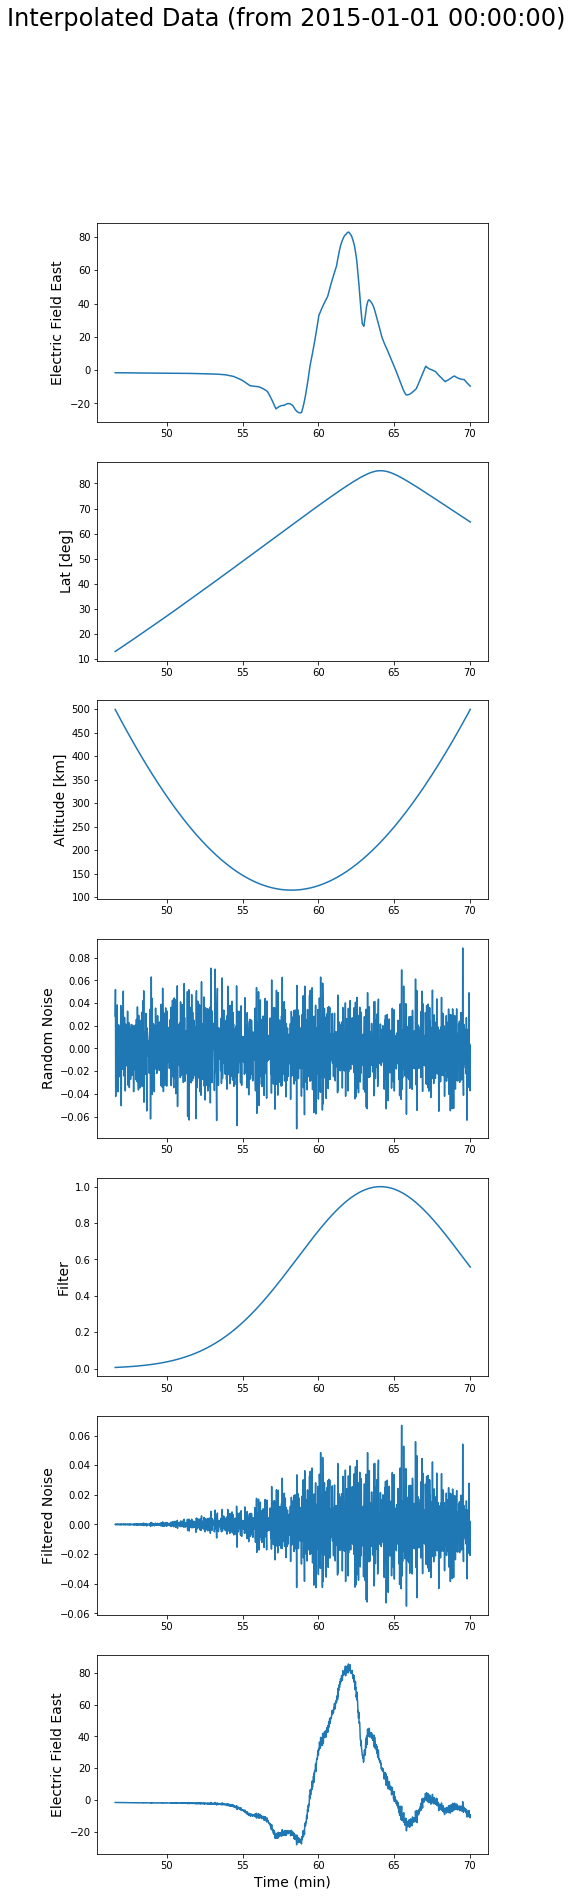

30000 Gaussian functions initialized.


100%|██████████| 1/1 [00:03<00:00,  3.51s/it]


In [11]:
LoadGUI()



